# LCF Analysis

This example uses LCF to analayse a large time resolved XAS dataset

In absence of further data, the process is:
Make a list of the files in the dataset, assuming the naming is tied to the time when spectra was collected.
- Read the first spectra, T<sub>0</sub>
- Read the last spectra, T<sub>n</sub>
- Set T<sub>0</sub> as the first component of the LCF
- Set T<sub>n</sub> as the second component of the LCF
- Do a binary search for the spectra T<sub>x</sub> where:
  - the weight from T<sub>0</sub> is ≅100%, that is T<sub>n</sub> starts being noticeable
  - the weight from T<sub>0</sub> ≅ T<sub>n</sub>, that is the contributions are close to 50/50
  - the weight from T<sub>n</sub> is ≅100%, that is T<sub>0</sub> starts descends below 1%

The binary search proceeds as follows:
1. Set the search range as \[0,n\]
2. Read the middle spectra T<sub>n/2</sub>
3. Do a LCF using T<sub>0</sub> and T<sub>n</sub>
4. Test and adjust search range:
    1. If searching for T<sub>0</sub> dominant:
        1. If the weight of T<sub>n</sub> is greather than 2%  set the range = \[n/2, n\] and repeat from 2.
        2. If the weight of T<sub>n</sub> is smaller than 2% set the range  = \[0, n/2\] and repeat from 2.
        3. Stop if range length <= 1 or weight T<sub>n</sub> less than 2 % and greather than 0 (no negatives)
    2. If searching for weight T<sub>0</sub> ≅ weight T<sub>n</sub>
        1. If the weight of T<sub>n</sub> is greather than the weight of T<sub>0</sub> set the search range  = \[0, n/2\] and repeat from 2.
        2. If the weight of T<sub>n</sub> is smaller than the weight of T<sub>0</sub> set the search range  = \[n/2, n\] and repeat from 2.
        3. stop if range length <= 1 
    3. If searching for T<sub>n</sub> dominant:
        1. If the weight of T<sub>0</sub> is smaller than 2% set the range  = \[n/2, n\] and repeat from 2.
        2. If the weight of T<sub>0</sub> is greather than 2%  set the range = \[0, n/2\] and repeat from 2.
        3. Stop if range length <= 1 or weight T<sub>0</sub> less than 2 % and greather than 0 (no negatives)


## Resources
Pyhon modules and libraries used in this example

In [1]:
# code for importing custom helper libraries
import sys

# working with zipped files
import zipfile

# moved all custom helper libraries to a level bellow this directory.
sys.path.append('../lib/')

# Library with the functions that provide the larch functionalities
# equivalent to those provided by athena including normalisation, 
# merging, re-binning, LCF and visualisation (plotting)
import manage_athena as athenamgr 

# library to read ascii files
# this should be in the athenamgr lib
from larch.io import read_ascii

# additional custom plot functions (replicate plots in published papers)
import custom_plots

# File handling
from pathlib import Path

# Handling json files
import json

# printing formated json data
import pprint

# to copy the mutable types like dictionaries, use copy/deepcopy 
import copy

# just print times
from datetime import datetime

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 


## Custom processing functions

In [2]:

def get_file_list_zip(zip_file = "", show_info = False):
    files_list = []
    if Path(zip_file).is_file():
        zip_data = zipfile.ZipFile(zip_file)
        files_list = zip_data.namelist()
    if show_info:
        print ("The first file is ", files_list [0])
        print ("The last file is ", files_list [-1])
        print (f"There are: {len(files_list)} files in the zip file")
    return files_list

def xas_from_zip(zip_file="", zipped_file_name="", columns = ""):
    work_dir = "./wd_temp"
    tmp_file = Path(zipped_file_name).name
    a_data_group = None
    if Path(zip_file).is_file():
        zip_data = zipfile.ZipFile(zip_file)
        # extract a specific file from the zip container
        f = zip_data.open(zipped_file_name)

        # save the extraced file 
        content = f.read()
               
        working_file = Path(work_dir, tmp_file)
    
        working_file.parents[0].mkdir(parents=True, exist_ok=True)
        
        f = open(working_file, 'wb')
        f.write(content)
        f.close()
        
        a_data_group = read_ascii(working_file, columns)
        
    return a_data_group

# LCF plot
def lcf_plot(group1, group2, xlim=[29180, 29230], show_comps = False):
    plt.grid(color='lightgrey', linestyle=':', linewidth=1) #show and format grid
    plt.plot(group1.energy, group1.norm, label=group1.label, linewidth=4,color='blue')
    plt.plot(group2.energy, group2.mu, label=group2.filename, linewidth=2, color='orange',linestyle='--')
    if show_comps:
        for one_comp in group2.ycomps:
            plt.plot(group2.energy, group2.ycomps[one_comp], label=one_comp, linewidth=2, linestyle=':')
    plt.title(group2.arrayname, fontsize=8)
    plt.legend() # show legend 
    plt.xlim(xlim)

    return plt


def plot_lcf_components(lcf_comps, offsets = [-20,30]):
    for a_dg in lcf_comps:
        plt = athenamgr.plot_mu(lcf_comps[a_dg])  
        plt.title("Plot components (first and last groups)")
        plt.xlim(lcf_comps[a_dg].e0+offsets[0],lcf_comps[a_dg].e0+offsets[1])
        print(lcf_comps[a_dg].filename, "E0:", lcf_comps[a_dg].e0)
    plt.show()

def get_components(zip_file_path, files_list, column_headres = "energy mu"):
    first_dg = xas_from_zip(zip_file_path, files_list [0], columns = column_headres)
    first_dg.filename = 'first'
    last_dg = xas_from_zip(zip_file_path, files_list [-1], columns = column_headres)
    last_dg.filename = 'last'
    lcf_comps = {"first": first_dg, "last": last_dg}
    for a_dg in lcf_comps:
        lcf_comps[a_dg] = athenamgr.calc_with_defaults(lcf_comps[a_dg])
    return lcf_comps

# test for even split of components:
def evenly_split(wgt_first, wgt_last, lower_v, higher_v, mid_v):
    # this condition finds the point closer to 50/50 split
    if wgt_first > wgt_last:
        lower_v = mid_v
    else:
        higher_v = mid_v
    return lower_v, higher_v

# test for the second component 
def higher_dominates(wgt_first, wgt_last, lower_v, higher_v, mid_v, test_val):
    if wgt_first >  test_val:
        lower_v = mid_v    
    else:
        higher_v = mid_v  
    return lower_v, higher_v

# test for the first component
def lower_dominates(wgt_first, wgt_last, lower_v, higher_v, mid_v, test_val):
    if wgt_last >  test_val:
        higher_v = mid_v     
    else:
        lower_v = mid_v
    return lower_v, higher_v



#test_even   1  # if looking for the place where the two signals are ~50/50
#test_lower  2  # if looking for the spectra where lower is ~ 100 % 
#test_higher 3  # if looking for the spectra where higher is ~ 100 % 
def find_lcf_match(path_to_zip = "", variables= {}, w_test=0):
    
    files_list = get_file_list_zip(path_to_zip, True)
    lcf_components = get_components(path_to_zip, files_list, "energy mu")
    plot_lcf_components(lcf_components)

    # set L and R
    lower_val = 0 
    higher_val = len(files_list)-1

    min_lim = lcf_components[variables['reference_standard']].e0+ variables['lower_limit']
    max_lim = lcf_components[variables['reference_standard']].e0+ variables['upper_limit']

    tested = {}
    start_timestamp = accu_time = None
    while higher_val > lower_val:
        # start test
        start_timestamp = datetime.utcnow()        
        mid_val = int(lower_val + (higher_val - lower_val) / 2)
        print(files_list[mid_val])
        test_dg = xas_from_zip(path_to_zip, files_list[mid_val], columns = "energy mu")
        test_dg = athenamgr.calc_with_defaults(test_dg)
        test_dg.label = variables['prefix'] + "{:05d}".format(mid_val)
        test_dg.filename = test_dg.label
        print(test_dg.e0)
        # do lcf of test group
        lcf_result = athenamgr.lcf_group(test_dg, 
                                         list(lcf_components.values()), 
                                         fit_limits=[min_lim, max_lim])
        
       
        weight_first = lcf_result.weights["first"] 
        weight_last = lcf_result.weights["last"] 
        print (lcf_result.weights)
        tested[mid_val] = [test_dg, lcf_result] 
        plt = lcf_plot(test_dg, lcf_result,[min_lim, max_lim],True)
        print("Goodness of LCF fit")
        print (test_dg.filename + " R Factor:\t", "%.4f" % lcf_result.rfactor)
        plt.show()
        
        weight_diff = 0.01
        if w_test == 1:
            lower_val, higher_val = evenly_split(weight_first, weight_last, lower_val, higher_val, mid_val)
            if abs(lower_val - higher_val) == 1:
                break
        elif w_test == 2:
            lower_val, higher_val = higher_dominates(weight_first, weight_last, lower_val, higher_val, mid_val, weight_diff)
            if abs(lower_val - higher_val) == 1 or (weight_first <  weight_diff and weight_first > 0):
                break
        elif w_test == 3:
            lower_val, higher_val = lower_dominates(weight_first, weight_last, lower_val, higher_val, mid_val, weight_diff)
            if abs(lower_val - higher_val) == 1 or (weight_last <  weight_diff and weight_last >  0.0):
                break
        else:
            print("No test selectected")
            break
        
        #end of test
        end_timestamp = datetime.utcnow()

        print ('Start:\t', start_timestamp)
        print ('End:\t', end_timestamp)
        print (end_timestamp-start_timestamp)
        if accu_time == None:
            accu_time = end_timestamp-start_timestamp
        else:
            accu_time += end_timestamp-start_timestamp
            
    print ("Run time:", accu_time)
    print ("Average run time:", accu_time/len(tested))
    
    print("*"*90)
    return tested


In [3]:
# zip file containign normalised mu for the experiment
rh4co = Path("../wf_data/non_pub", "37119_Rh_4_CO_Oxidation_53_second_ascii_r.zip")
#rh4co = Path("../wf_data/non_pub", "37123_Rh_4_CO_Oxidation_45_7_ascii.zip") 

# parameters for lcf 
task_lcf = {'name': 'lcf',
            'sequence': 1,
            'variables': {'lcf_components': ['first', 'last'],
                          'reference_standard': 'first',
                          'lower_limit': -20,
                          'upper_limit': 30,
                          'prefix':"rh4co_ox_45_"}}

The first file is  37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00000.dat
The last file is  37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03579.dat
There are: 3580 files in the zip file
first E0: 23224.387
last E0: 23225.748


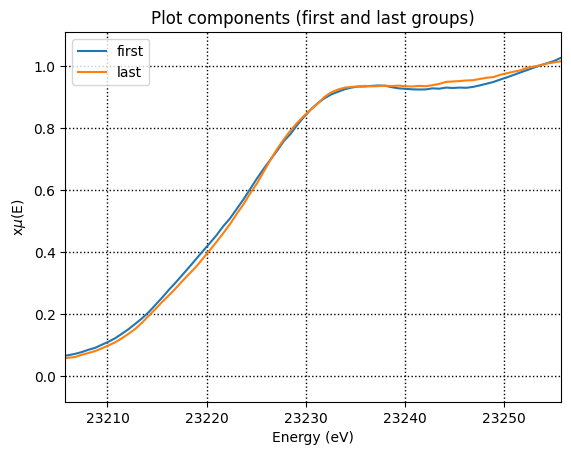

37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_01789.dat
23225.067
OrderedDict([('first', 0.8454754422110163), ('last', 0.15452457038754952)])
Goodness of LCF fit
rh4co_ox_45_01789 R Factor:	 0.0000


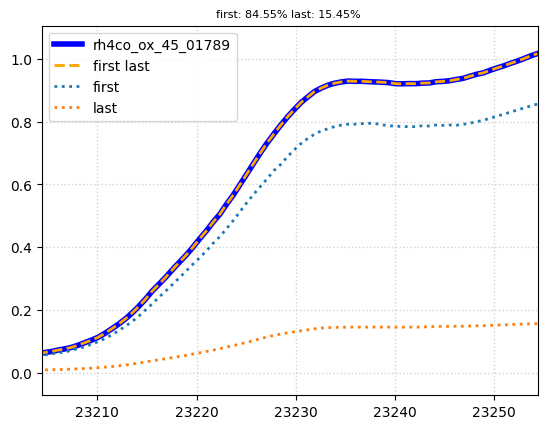

Start:	 2024-07-23 14:22:26.810013
End:	 2024-07-23 14:22:27.130472
0:00:00.320459
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02684.dat
23225.067
OrderedDict([('first', 0.16074761125657078), ('last', 0.8392523911387553)])
Goodness of LCF fit
rh4co_ox_45_02684 R Factor:	 0.0000


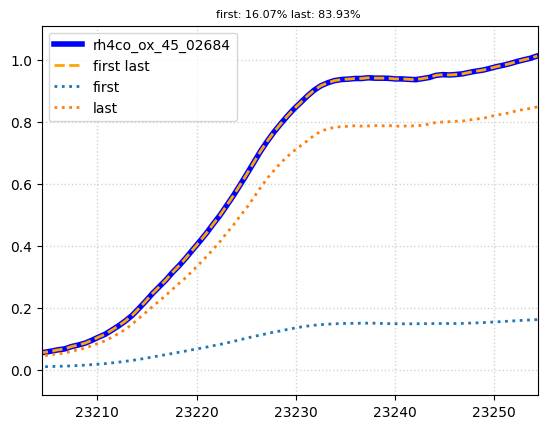

Start:	 2024-07-23 14:22:27.130472
End:	 2024-07-23 14:22:27.466704
0:00:00.336232
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02236.dat
23225.067
OrderedDict([('first', 0.5342767399630097), ('last', 0.4657232679983341)])
Goodness of LCF fit
rh4co_ox_45_02236 R Factor:	 0.0000


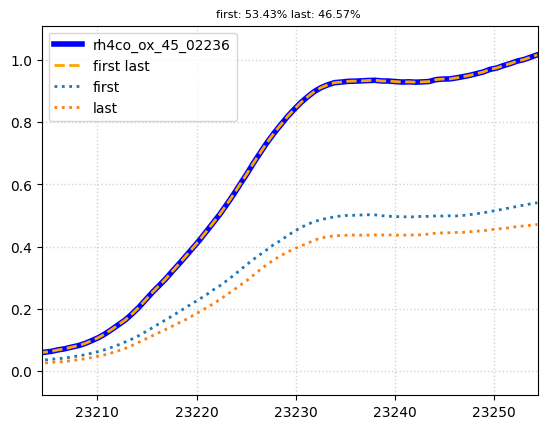

Start:	 2024-07-23 14:22:27.466704
End:	 2024-07-23 14:22:27.889120
0:00:00.422416
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02460.dat
23225.067
OrderedDict([('first', 0.09513381788572232), ('last', 0.9048661835318821)])
Goodness of LCF fit
rh4co_ox_45_02460 R Factor:	 0.0000


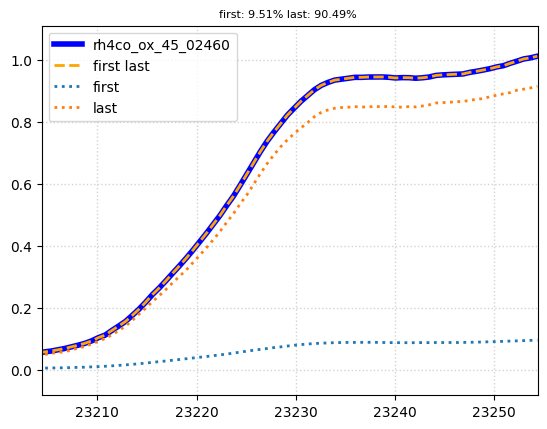

Start:	 2024-07-23 14:22:27.889120
End:	 2024-07-23 14:22:28.424309
0:00:00.535189
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02348.dat
23225.067
OrderedDict([('first', 0.30212590148339624), ('last', 0.6978741030186305)])
Goodness of LCF fit
rh4co_ox_45_02348 R Factor:	 0.0000


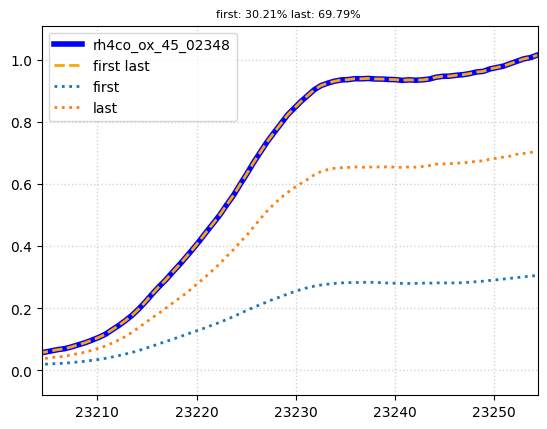

Start:	 2024-07-23 14:22:28.424309
End:	 2024-07-23 14:22:28.879601
0:00:00.455292
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02292.dat
23225.067
OrderedDict([('first', 0.4217377668449673), ('last', 0.5782622394394152)])
Goodness of LCF fit
rh4co_ox_45_02292 R Factor:	 0.0000


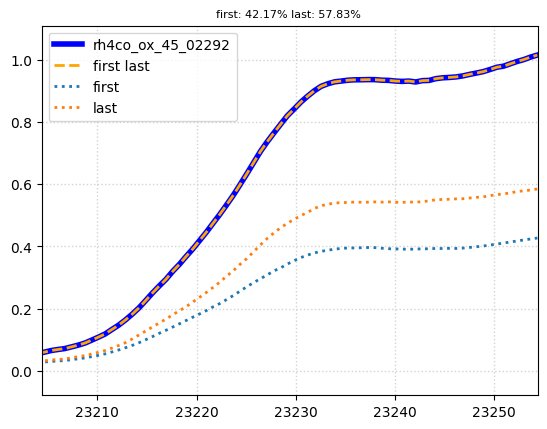

Start:	 2024-07-23 14:22:28.879601
End:	 2024-07-23 14:22:29.298275
0:00:00.418674
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02264.dat
23225.067
OrderedDict([('first', 0.3094315031347288), ('last', 0.6905685014761599)])
Goodness of LCF fit
rh4co_ox_45_02264 R Factor:	 0.0000


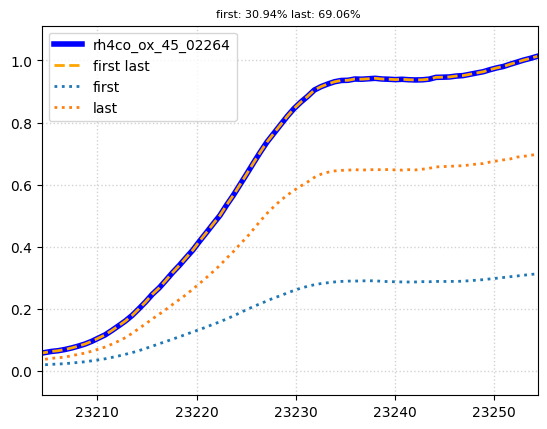

Start:	 2024-07-23 14:22:29.298275
End:	 2024-07-23 14:22:29.748353
0:00:00.450078
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02250.dat
23225.067
OrderedDict([('first', 0.5300529979130963), ('last', 0.4699470099853088)])
Goodness of LCF fit
rh4co_ox_45_02250 R Factor:	 0.0000


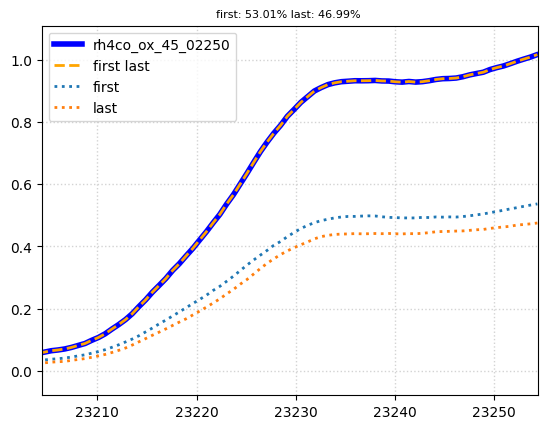

Start:	 2024-07-23 14:22:29.749353
End:	 2024-07-23 14:22:30.298946
0:00:00.549593
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02257.dat
23225.067
OrderedDict([('first', 0.5366945034484328), ('last', 0.4633055045489385)])
Goodness of LCF fit
rh4co_ox_45_02257 R Factor:	 0.0000


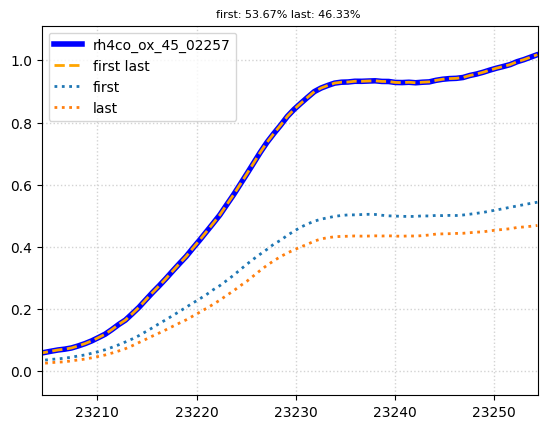

Start:	 2024-07-23 14:22:30.298946
End:	 2024-07-23 14:22:30.727208
0:00:00.428262
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02260.dat
23225.067
OrderedDict([('first', 0.3738511470164363), ('last', 0.62614885855438)])
Goodness of LCF fit
rh4co_ox_45_02260 R Factor:	 0.0000


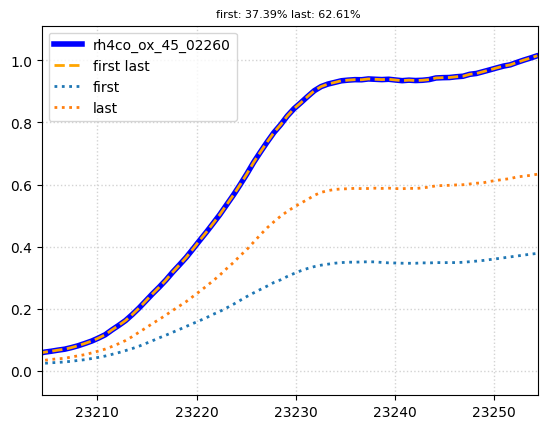

Start:	 2024-07-23 14:22:30.727208
End:	 2024-07-23 14:22:31.146515
0:00:00.419307
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02258.dat
23225.067
OrderedDict([('first', 0.5192266725534566), ('last', 0.48077333518362386)])
Goodness of LCF fit
rh4co_ox_45_02258 R Factor:	 0.0000


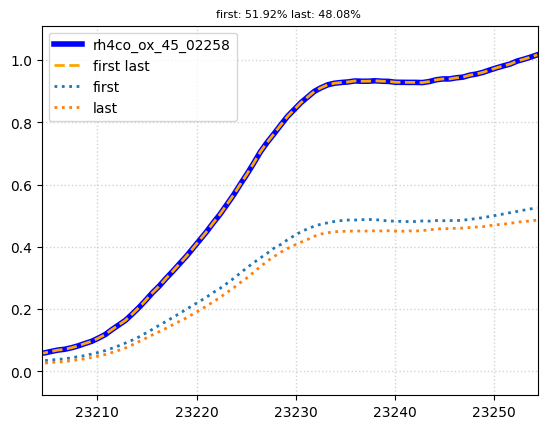

Start:	 2024-07-23 14:22:31.146515
End:	 2024-07-23 14:22:31.644990
0:00:00.498475
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02259.dat
23225.067
OrderedDict([('first', 0.4397906742051254), ('last', 0.5602093323482663)])
Goodness of LCF fit
rh4co_ox_45_02259 R Factor:	 0.0000


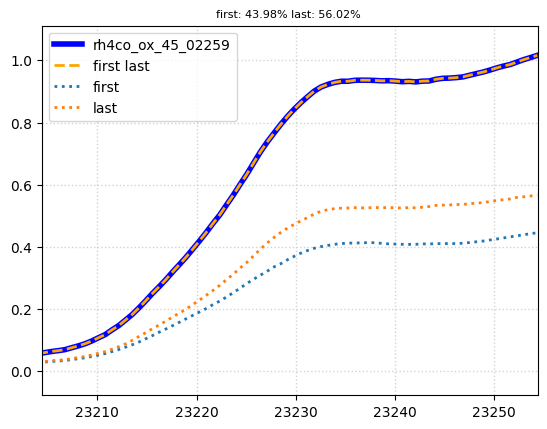

Run time: 0:00:04.833977
Average run time: 0:00:00.402831
******************************************************************************************


In [4]:
# look for 50/50 split 

search_1 = find_lcf_match(rh4co, task_lcf['variables'], w_test=1)

In [5]:
search_1[list(search_1.keys())[-1]][1].result

The first file is  37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00000.dat
The last file is  37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03579.dat
There are: 3580 files in the zip file
first E0: 23224.387
last E0: 23225.748


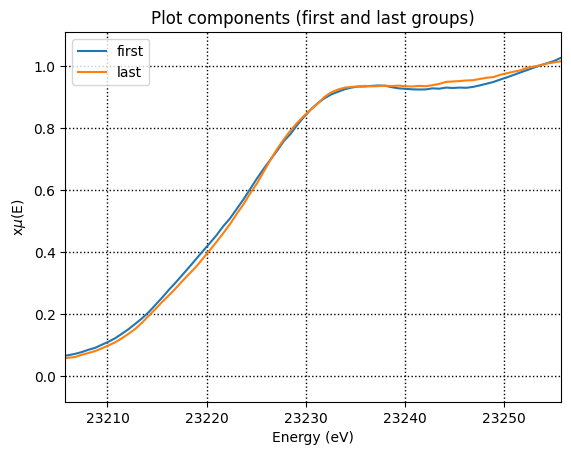

37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_01789.dat
23225.067
OrderedDict([('first', 0.8454754422110163), ('last', 0.15452457038754952)])
Goodness of LCF fit
rh4co_ox_45_01789 R Factor:	 0.0000


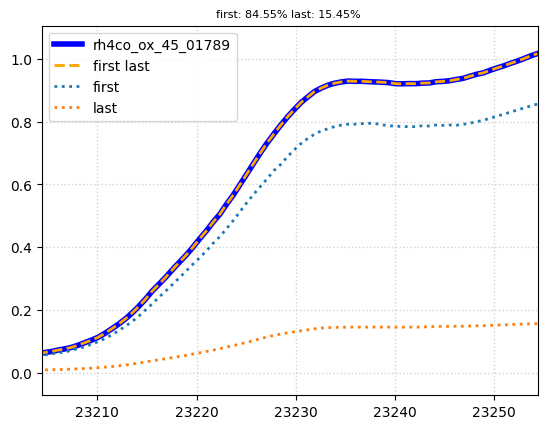

Start:	 2024-07-23 14:22:32.741068
End:	 2024-07-23 14:22:33.168991
0:00:00.427923
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02684.dat
23225.067
OrderedDict([('first', 0.16074761125657078), ('last', 0.8392523911387553)])
Goodness of LCF fit
rh4co_ox_45_02684 R Factor:	 0.0000


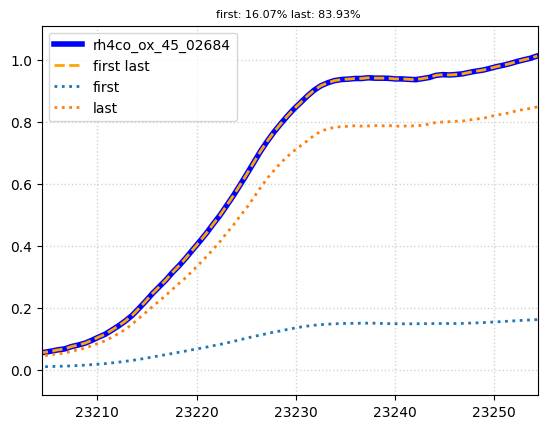

Start:	 2024-07-23 14:22:33.170033
End:	 2024-07-23 14:22:33.462845
0:00:00.292812
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03131.dat
23225.748
OrderedDict([('first', -0.030331925555018416), ('last', 1.0303319260069994)])
Goodness of LCF fit
rh4co_ox_45_03131 R Factor:	 0.0000


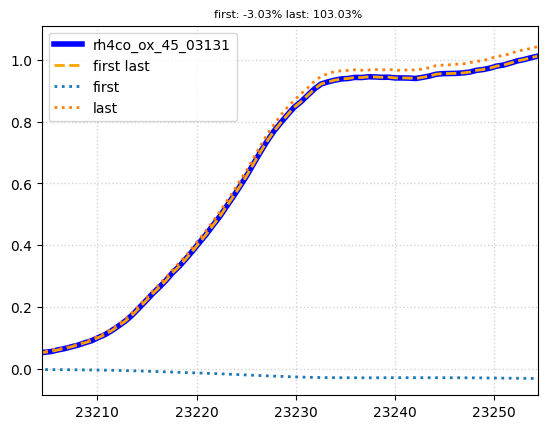

Start:	 2024-07-23 14:22:33.462845
End:	 2024-07-23 14:22:33.862326
0:00:00.399481
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_02907.dat
23225.067
OrderedDict([('first', 0.09399232213698529), ('last', 0.9060076792636095)])
Goodness of LCF fit
rh4co_ox_45_02907 R Factor:	 0.0000


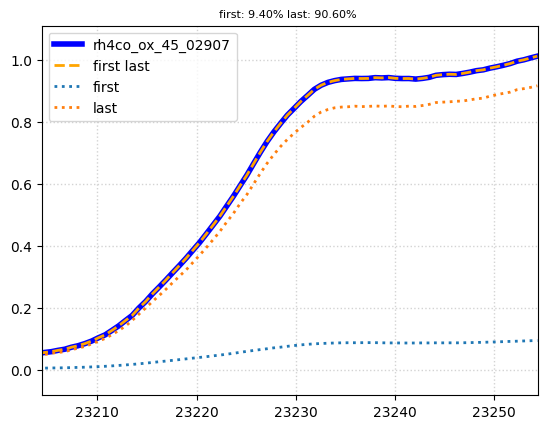

Start:	 2024-07-23 14:22:33.862326
End:	 2024-07-23 14:22:34.331197
0:00:00.468871
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03019.dat
23225.748
OrderedDict([('first', 0.025601522129585486), ('last', 0.974398478251907)])
Goodness of LCF fit
rh4co_ox_45_03019 R Factor:	 0.0000


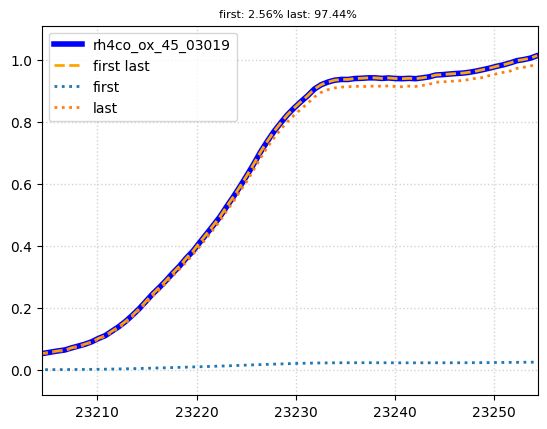

Start:	 2024-07-23 14:22:34.331197
End:	 2024-07-23 14:22:34.829757
0:00:00.498560
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03075.dat
23225.067
OrderedDict([('first', 0.05748177678201155), ('last', 0.9425182240745337)])
Goodness of LCF fit
rh4co_ox_45_03075 R Factor:	 0.0000


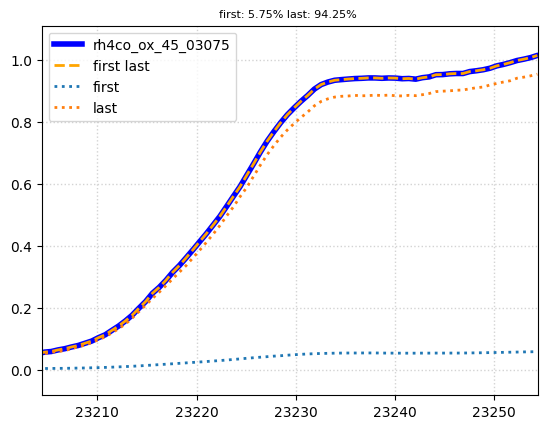

Start:	 2024-07-23 14:22:34.829757
End:	 2024-07-23 14:22:35.208245
0:00:00.378488
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03103.dat
23225.067
OrderedDict([('first', 0.040391117460927495), ('last', 0.959608883140947)])
Goodness of LCF fit
rh4co_ox_45_03103 R Factor:	 0.0000


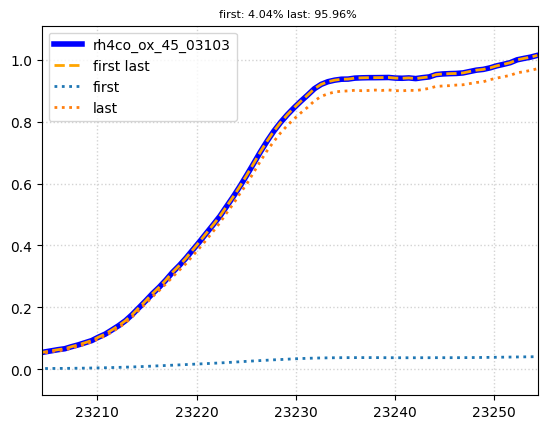

Start:	 2024-07-23 14:22:35.208245
End:	 2024-07-23 14:22:35.716380
0:00:00.508135
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03117.dat
23225.748
OrderedDict([('first', -0.051763804584639944), ('last', 1.0517638053559808)])
Goodness of LCF fit
rh4co_ox_45_03117 R Factor:	 0.0000


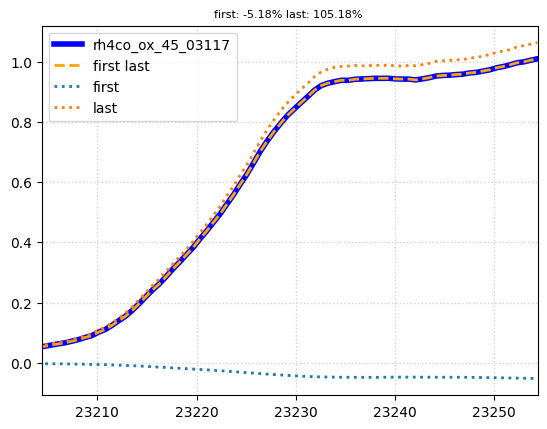

Start:	 2024-07-23 14:22:35.716380
End:	 2024-07-23 14:22:36.223133
0:00:00.506753
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03110.dat
23225.748
OrderedDict([('first', -0.09459080535918207), ('last', 1.094590806768695)])
Goodness of LCF fit
rh4co_ox_45_03110 R Factor:	 0.0000


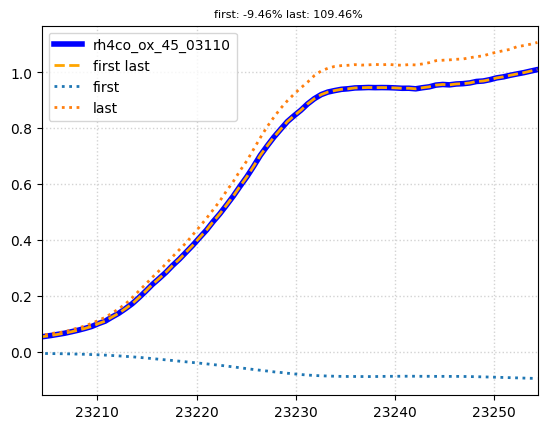

Start:	 2024-07-23 14:22:36.223133
End:	 2024-07-23 14:22:36.586075
0:00:00.362942
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03106.dat
23225.067
OrderedDict([('first', -0.009873176232071531), ('last', 1.0098731763791933)])
Goodness of LCF fit
rh4co_ox_45_03106 R Factor:	 0.0000


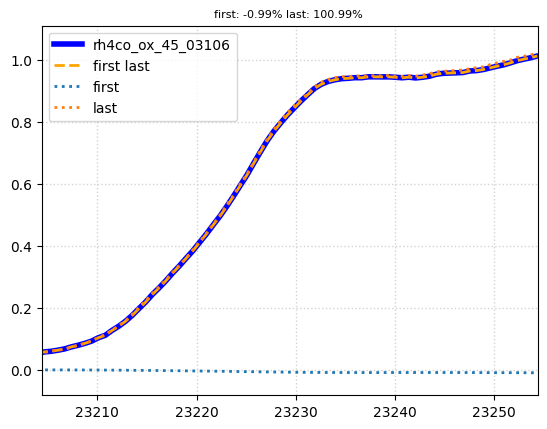

Start:	 2024-07-23 14:22:36.587074
End:	 2024-07-23 14:22:36.980062
0:00:00.392988
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03104.dat
23225.067
OrderedDict([('first', 0.0622515567748097), ('last', 0.9377484441528108)])
Goodness of LCF fit
rh4co_ox_45_03104 R Factor:	 0.0000


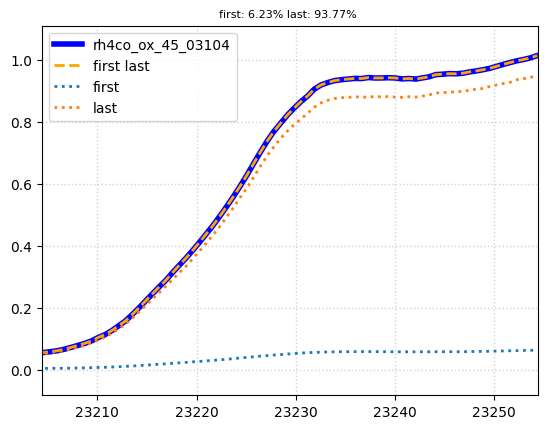

Start:	 2024-07-23 14:22:36.980062
End:	 2024-07-23 14:22:37.454690
0:00:00.474628
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03105.dat
23225.748
OrderedDict([('first', 0.027559639575090444), ('last', 0.9724403608355802)])
Goodness of LCF fit
rh4co_ox_45_03105 R Factor:	 0.0000


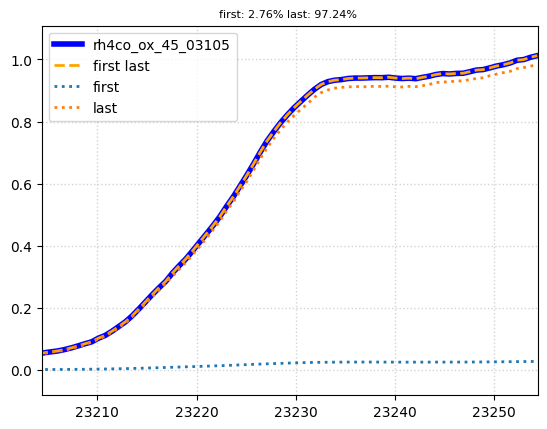

Run time: 0:00:04.711581
Average run time: 0:00:00.392632
******************************************************************************************


In [6]:
# look for a combination where last is dominant 
search_2 = find_lcf_match(rh4co, task_lcf['variables'], w_test=2)

In [7]:
search_2[list(search_2.keys())[-1]][1].result

The first file is  37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00000.dat
The last file is  37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_03579.dat
There are: 3580 files in the zip file
first E0: 23224.387
last E0: 23225.748


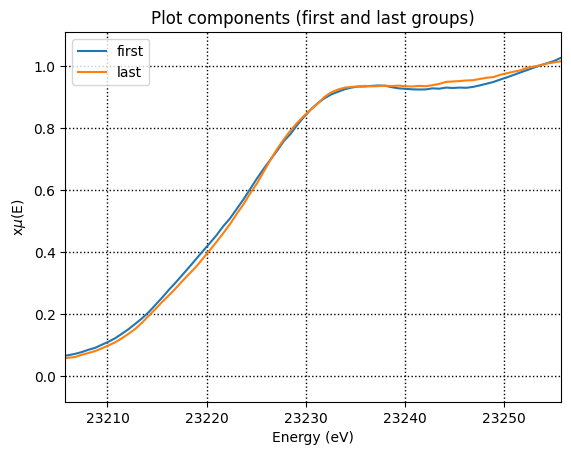

37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_01789.dat
23225.067
OrderedDict([('first', 0.8454754422110163), ('last', 0.15452457038754952)])
Goodness of LCF fit
rh4co_ox_45_01789 R Factor:	 0.0000


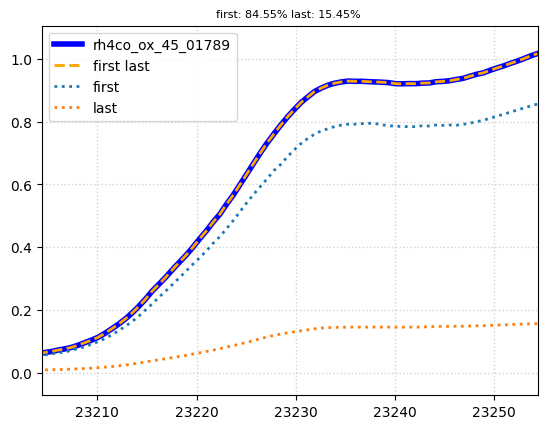

Start:	 2024-07-23 14:22:38.530917
End:	 2024-07-23 14:22:38.810940
0:00:00.280023
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00894.dat
23225.067
OrderedDict([('first', 0.9791020523732126), ('last', 0.02089796221654494)])
Goodness of LCF fit
rh4co_ox_45_00894 R Factor:	 0.0000


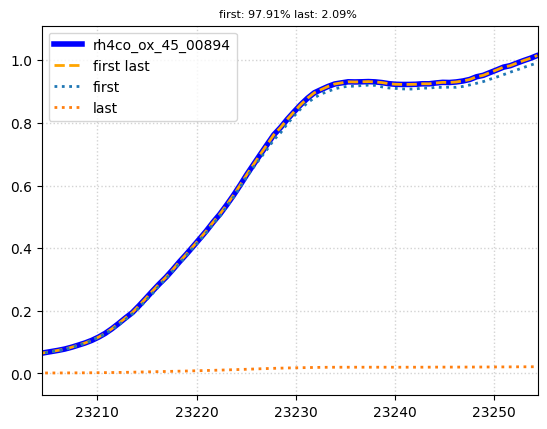

Start:	 2024-07-23 14:22:38.810940
End:	 2024-07-23 14:22:39.259567
0:00:00.448627
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00447.dat
23224.387
OrderedDict([('first', 1.0063278724109233), ('last', -0.006327857415469262)])
Goodness of LCF fit
rh4co_ox_45_00447 R Factor:	 0.0000


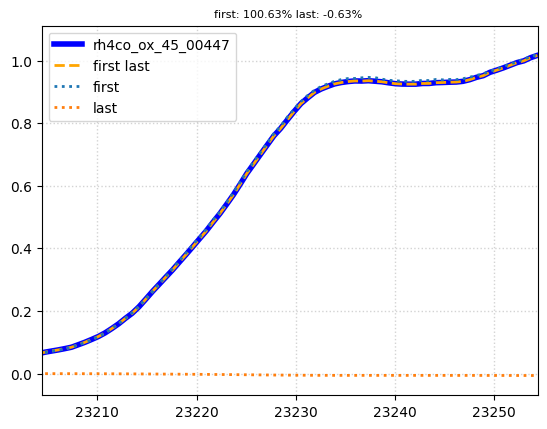

Start:	 2024-07-23 14:22:39.259567
End:	 2024-07-23 14:22:39.798380
0:00:00.538813
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00670.dat
23224.387
OrderedDict([('first', 0.9875568614317587), ('last', 0.012443153283985264)])
Goodness of LCF fit
rh4co_ox_45_00670 R Factor:	 0.0000


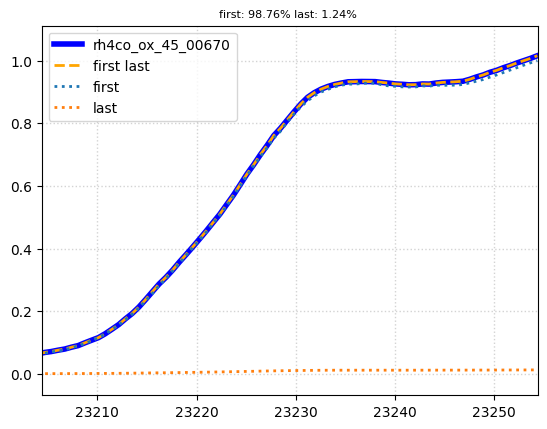

Start:	 2024-07-23 14:22:39.798380
End:	 2024-07-23 14:22:40.144455
0:00:00.346075
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00558.dat
23224.387
OrderedDict([('first', 0.9856620450990463), ('last', 0.014337969588462784)])
Goodness of LCF fit
rh4co_ox_45_00558 R Factor:	 0.0000


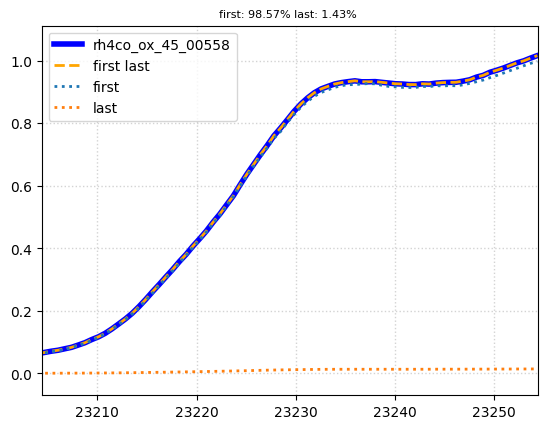

Start:	 2024-07-23 14:22:40.145510
End:	 2024-07-23 14:22:40.546637
0:00:00.401127
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00502.dat
23224.387
OrderedDict([('first', 1.0027909866901001), ('last', -0.0027909717473499907)])
Goodness of LCF fit
rh4co_ox_45_00502 R Factor:	 0.0000


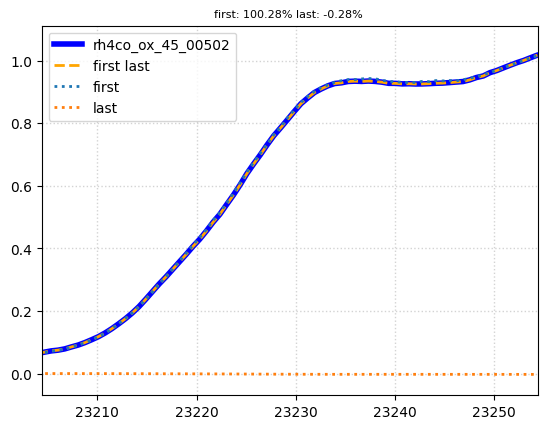

Start:	 2024-07-23 14:22:40.547644
End:	 2024-07-23 14:22:40.862784
0:00:00.315140
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00530.dat
23224.387
OrderedDict([('first', 0.9815219811621535), ('last', 0.018478033463663834)])
Goodness of LCF fit
rh4co_ox_45_00530 R Factor:	 0.0000


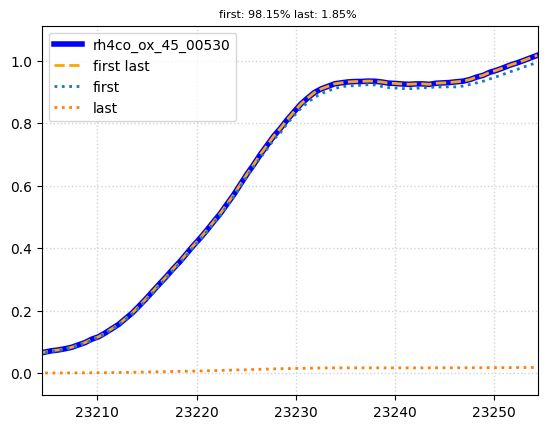

Start:	 2024-07-23 14:22:40.862784
End:	 2024-07-23 14:22:41.266660
0:00:00.403876
37119_Rh_4_CO_Oxidation_53_second_ascii/37119_Rh_4_CO_Oxidation_53_second_rh4co_ox_53_00516.dat
23224.387
OrderedDict([('first', 0.9989222802753581), ('last', 0.0010777346097438079)])
Goodness of LCF fit
rh4co_ox_45_00516 R Factor:	 0.0000


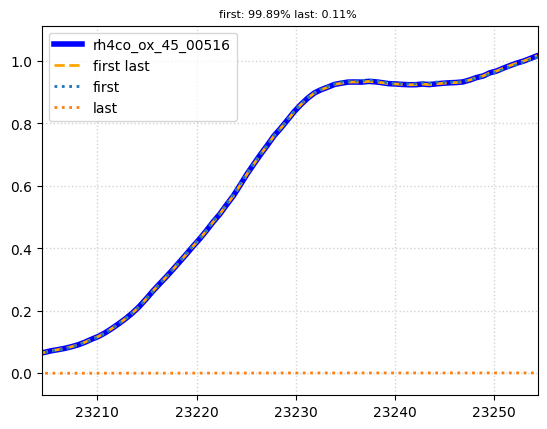

Run time: 0:00:02.733681
Average run time: 0:00:00.341710
******************************************************************************************


In [8]:
# look for a combination where first is dominant 
search_3 = find_lcf_match(rh4co, task_lcf['variables'], w_test=3)

In [9]:
search_3[list(search_3.keys())[-1]][1].result

rh4co_ox_45_00516 (first dominant) E0: 23224.387
rh4co_ox_45_02259 (50/50) 		E0: 23225.067
rh4co_ox_45_03105 (last dominant) 	E0: 23225.748


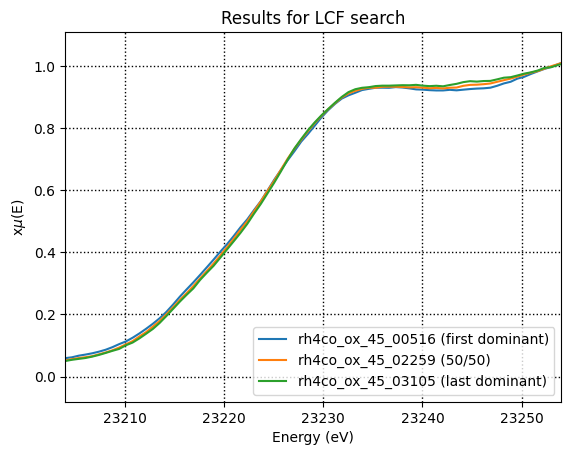

In [10]:
# plot the three results together
res_01 = search_1[list(search_1.keys())[-1]]
res_01[0].filename = res_01[0].label + " (50/50)"
res_02 = search_2[list(search_2.keys())[-1]]
res_02[0].filename = res_02[0].label + " (last dominant)"
res_03 = search_3[list(search_3.keys())[-1]]
res_03[0].filename = res_03[0].label + " (first dominant)"
plt = athenamgr.plot_mu(res_03[0])
plt = athenamgr.plot_mu(res_01[0])  
plt.xlim(round(res_01[1].xmin),round(res_01[1].xmax))
plt = athenamgr.plot_mu(res_02[0])

plt.title("Results for LCF search")

print(res_03[0].filename, "E0:", res_03[0].e0)
print(res_01[0].filename, "\t\tE0:", res_01[0].e0)
print(res_02[0].filename, "\tE0:", res_02[0].e0)


<Figure size 1800x300 with 0 Axes>

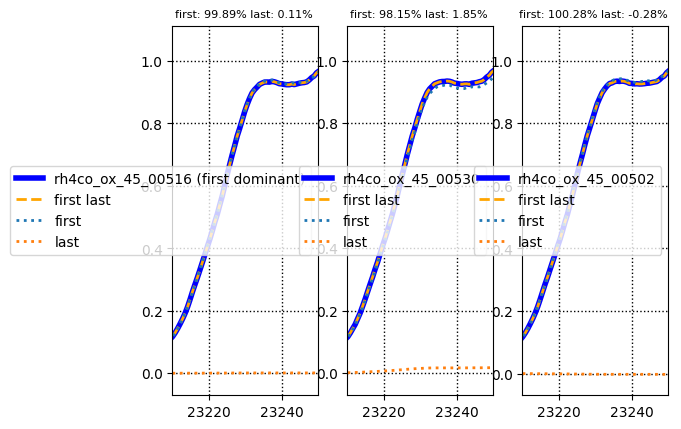

In [11]:
import importlib
importlib.reload(custom_plots)
plt = custom_plots.compare_3_lcf_plot(list(search_3.values()),[23210, 23250], True)
plt.show()

<Figure size 1800x300 with 0 Axes>

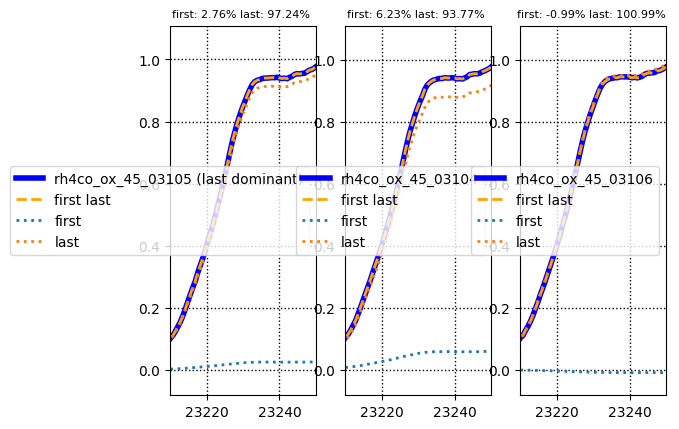

In [12]:
plt = custom_plots.compare_3_lcf_plot(list(search_2.values()),[23210, 23250], True)
plt.show()

<Figure size 1800x300 with 0 Axes>

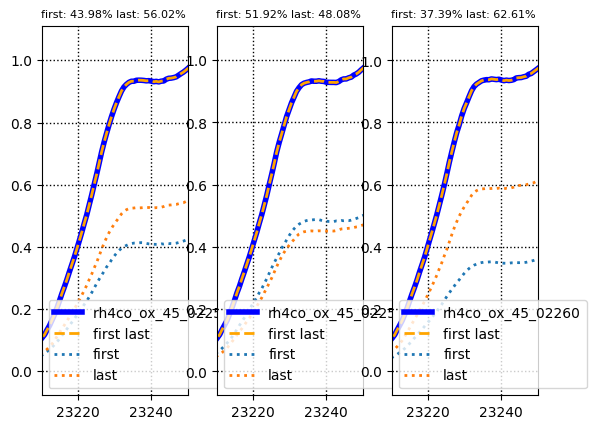

In [13]:
plt = custom_plots.compare_3_lcf_plot(list(search_1.values()),[23210, 23250], True)
plt.show()

In [14]:
len(search_1), len(search_2),len(search_3)

(12, 12, 8)